## Comparing methods of calculating weighted regional and global means

### Import packages

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import esmlab

### Load in some test data

In [2]:
scr_dir = '/glade/scratch/kdagon/archive/'
case_name = 'hydro_ensemble_default_params'
file_path = scr_dir+case_name+'/lnd/hist/'
print(file_path)

/glade/scratch/kdagon/archive/hydro_ensemble_default_params/lnd/hist/


Specify model year to read in

In [3]:
model_yr = 30

In [4]:
fils_in = xr.open_mfdataset(file_path+'*.clm2.h0.00'+str(model_yr)+'*.nc', combine='by_coords')

In [5]:
fils_in

<xarray.Dataset>
Dimensions:                 (cft: 2, glc_nec: 10, hist_interval: 2, lat: 46, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lon: 72, ltype: 9, natpft: 15, nvegwcs: 4, time: 12)
Coordinates:
  * levgrnd                 (levgrnd) float32 0.01 0.04 ... 28.870724 41.998436
  * lat                     (lat) float32 -90.0 -86.0 -82.0 ... 82.0 86.0 90.0
  * lon                     (lon) float32 0.0 5.0 10.0 ... 345.0 350.0 355.0
  * levlak                  (levlak) float32 0.05 0.6 2.1 ... 25.6 34.325 44.775
  * levdcmp                 (levdcmp) float32 1.0
  * time                    (time) object 0030-02-01 00:00:00 ... 0031-01-01 00:00:00
Dimensions without coordinates: cft, glc_nec, hist_interval, levsoi, ltype, natpft, nvegwcs
Data variables:
    mcdate                  (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mcsec                   (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdcur                   (time) int32 dask.array<chunksiz

### Pull out a specific output variable

In [8]:
TSA = fils_in.TSA # this is now a DataArray of 2m air temperature
TSA

<xarray.DataArray 'TSA' (time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(12, 46, 72), dtype=float32, chunksize=(1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time     (time) object 0030-02-01 00:00:00 ... 0031-01-01 00:00:00
Attributes:
    long_name:     2m air temperature
    units:         K
    cell_methods:  time: mean

### Annual mean to make calculations simpler

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


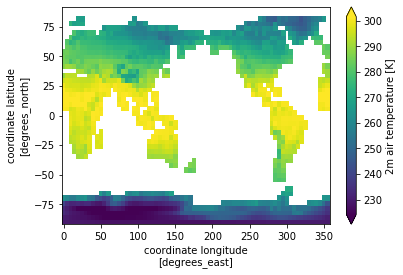

In [29]:
TSA_amean = TSA.mean(dim='time')
TSA_amean.plot(robust=True);

### Gridcell area and landfrac info (first time index)

In [62]:
area = fils_in.area[0]
landfrac = fils_in.landfrac[0]

### Calculate area weights

In [32]:
arwt = area * landfrac

<xarray.DataArray (lat: 46, lon: 72)>
dask.array<mul, shape=(46, 72), dtype=float32, chunksize=(46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
    time     object 0030-02-01 00:00:00
Attributes:
    long_name:  grid cell areas
    units:      km^2

In [33]:
# re-assign long_name attribute
arwt.attrs['long_name'] = 'grid cell areas multiplied by landfrac'

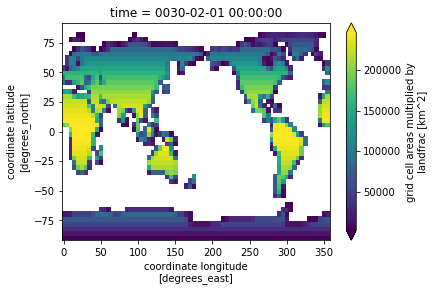

In [15]:
# quick plot of area weights
arwt.plot(robust=True);

### Normalize arwt: 2 methods!

In [20]:
# normalize by sum of area weights
arwt_norm_sum = arwt/arwt.sum()
arwt_norm_sum.attrs['long_name'] = 'area weights normalized by sum'

In [40]:
arwt_norm_sum

<xarray.DataArray (lat: 46, lon: 72)>
dask.array<truediv, shape=(46, 72), dtype=float32, chunksize=(46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
    time     object 0030-02-01 00:00:00
Attributes:
    long_name:  area weights normalized by sum
    units:      km^2

In [21]:
# normalize by maximum of area weights
arwt_norm_max = arwt/arwt.max()
arwt_norm_max.attrs['long_name'] = 'area weights normalized by max'

### Global means with both methods

In [70]:
# Needed help with getting scalar output from 2D weighted means: https://github.com/NCAR/esmlab/issues/28
# Not sure why the true_divide warning shows up
TSA_glob_mean_arwt_sum = esmlab.statistics.weighted_mean(TSA_amean, dim=['lat','lon'], weights=arwt_norm_sum).load().values
TSA_glob_mean_arwt_sum

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.07242, dtype=float32)

In [76]:
TSA_glob_mean_arwt_max = esmlab.statistics.weighted_mean(TSA_amean, dim=['lat','lon'], weights=arwt_norm_max).load().values
TSA_glob_mean_arwt_max

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.07245, dtype=float32)

### Generate weights using cosine of latitudes

In [57]:
lats = fils_in.lat

In [65]:
# np.cos expects input in radians
cwt = np.cos(lats * np.pi / 180.)

In [77]:
TSA_glob_mean_cwt = esmlab.statistics.weighted_mean(TSA_amean, dim=['lat'], weights=cwt).mean().values
TSA_glob_mean_cwt

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(279.76453, dtype=float32)

### TO DO: calc area weights (arwt) with 2 different normalizations, esmlab weighted means function, cos(latitude) weighting, other NCL/tutorial methods?
### Test global and regional both methods

### Plot results so far

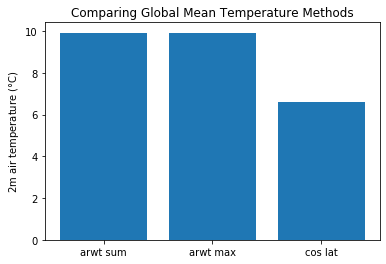

In [92]:
x = np.arange(3)
means = [TSA_glob_mean_arwt_sum, TSA_glob_mean_arwt_max, TSA_glob_mean_cwt]
means_c = [x - 273.15 for x in means]
plt.bar(x,means_c)
plt.title("Comparing Global Mean Temperature Methods")
plt.ylabel("2m air temperature ($\degree$C)")
plt.xticks(x, ('arwt sum','arwt max','cos lat'));

In [ ]:
# Note: values seem low? Due to 4x5? only one year?